In [6]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from brainlit.BrainLine.parse_ara import *
import networkx as nx
import seaborn as sns
from statannotations.Annotator import Annotator
import pandas as pd
import brainrender
import scipy.ndimage as ndi
from skimage.morphology import skeletonize
from brainlit.BrainLine.data.axon_data import brain2paths as brain2paths_axon
from brainlit.BrainLine.util import find_sample_names, json_to_points
from brainlit.BrainLine.data.soma_data import brain2paths as brain2paths_soma
import os
import scipy.ndimage as ndi
import random
from cloudvolume import CloudVolume

%gui qt5

# Axon

## Intensity Histograms

In [ ]:
data = {
    "8649": ([2192, 1244, 1332], [901, 2559, 1332]),
    "8650": ([2378, 948, 1851], [2302, 5705, 1851]),
    "8589": ([4312, 4163, 1450], [1335, 6119, 1450]),
    "8613": ([3911, 3461, 1514], [1411, 5720, 1514]),
    "8590": ([1394, 1940, 1854], [4776, 816, 1854]),
}  # axon center then nonaxon center

data2 = {}
for i in ["8650", "8589", "8590"]:
    data2[i] = data[i]
data = data2

intensities = []
brain_ids = []
vol_type = []
# viewer = napari.Viewer(ndisplay=2)


for i, brain in enumerate(data.keys()):
    vol = CloudVolume(brain2paths_axon[brain]["base"] + "Ch_647")
    coord = data[brain][0]
    subvol = vol[
        coord[0] - 9 : coord[0] + 10,
        coord[1] - 9 : coord[1] + 10,
        coord[2] - 9 : coord[2] + 10,
    ]
    # viewer.add_image(np.squeeze(subvol), name=f"{brain} axon", scale = [1.83, 1.83, 2])
    num_entries = len(subvol.flatten())
    intensities += list(subvol.flatten())
    brain_ids += [i] * num_entries
    vol_type += [f"Axon"] * num_entries

    coord = data[brain][1]
    subvol = vol[
        coord[0] - 9 : coord[0] + 10,
        coord[1] - 9 : coord[1] + 10,
        coord[2] - 9 : coord[2] + 10,
    ]
    # viewer.add_image(np.squeeze(subvol), name=f"{brain} bg", scale = [1.83, 1.83, 2])
    num_entries = len(subvol.flatten())
    intensities += list(subvol.flatten())
    brain_ids += [i] * num_entries
    vol_type += [f"Background"] * num_entries

# # viewer.camera.angles = [45, 45, 45]
# viewer.scale_bar.visible = True
# viewer.scale_bar.unit = "um"
df = pd.DataFrame(
    data={"Intensity": intensities, "Subvolume Type": vol_type, "Sample": brain_ids}
)

In [ ]:
sns.set(font_scale=1.15)
fig, axs = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(5, 5))

for i in range(3):
    hist = sns.histplot(
        data=df[df["Sample"] == i],
        x="Intensity",
        hue="Subvolume Type",
        ax=axs[i],
        palette=["green", "red"],
    )
    axs[i].set_title(f"Sample {i}")
    if i > 0:
        hist.get_legend().remove()
plt.tight_layout()

## Compare to sample number

In [12]:
# training set results
training_brain_order = [3, 4, 8649, 8788]
models_diff = []
models_same = []

for i, brain in enumerate(training_brain_order):
    model_diff = "-compare"
    for j, brain2 in enumerate(training_brain_order[: i + 1]):
        model_diff += "-"
        model_diff += str(brain2)

        model_same = "-compare-3"
        if j > 0:
            model_same += f"_{j+1}"

    models_diff.append(model_diff)
    models_same.append(model_same)

print(f"heterogeneous: {models_diff} homogeneous: {models_same}")

heterogeneous: ['-compare-3', '-compare-3-4', '-compare-3-4-8649', '-compare-3-4-8649-8788'] homogeneous: ['-compare-3', '-compare-3_2', '-compare-3_3', '-compare-3_4']


In [24]:
os.listdir(brain_dir)

[
    'val_9.h5',
    'val_2_Probabilities.h5',
    'val_9_Probabilities.h5',
    '.DS_Store',
    'val_7-image_3channel_Labels.h5',
    'val_3-image_3channel_Labels.h5',
    'val_8.h5',
    'val_6_Probabilities.h5',
    'val_2-image_3channel_Labels.h5',
    'results-3',
    'val_3.h5',
    'val_3_Probabilities.h5',
    'val_6-image_3channel_Labels.h5',
    'images_only',
    'val_7.h5',
    'val_8_Probabilities.h5',
    'results-compare-3-4-8649',
    'val_6.h5',
    'val_7_Probabilities.h5',
    'val_2.h5',
    'results-compare-3-4-8649-8788',
    'results-3-4-8649',
    'val_5.h5',
    'val_8-image_3channel_Labels.h5',
    'val_1.h5',
    'val_4-image_3channel_Labels.h5',
    'val_0_Probabilities.h5',
    'results-3-4',
    'val_0-image_3channel_Labels.h5',
    'val_4_Probabilities.h5',
    'val_0.h5',
    'results-compare-3',
    'val_4.h5',
    'results-compare-3_4',
    'results-compare-3_3',
    'results-3-4-8649-8788',
    'results-compare-3_2',
    'val_1_Probabilities.h5',
    'val_9-image_3channel_Labels.h5',
    'val_5_Probabilities.h5',
    'brain8589_val.ilp',
    'val_1-image_3channel_Labels.h5',
    'results-compare-3-4',
    'val_5-image_3channel_Labels.h5'
]

In [25]:
brain_order = [8650, 8613, 8589, 8590, 8786, 8790, 11537]  # , 8649, 8788]
training_set_sizes = [10, 20, 25, 30]
train_sizes = []
model_lines = []
fscores = []
brains = []

for brain in tqdm(brain_order, desc="Evaluating brains..."):
    brain_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_axon/brain{brain}/"
    # identify images an split into val and test

    for file in os.listdir(brain_dir):
        if "3channel" in file:
            suffix = "-image_3channel_Labels.h5"
            break
        elif "2channel" in file:
            suffix = "-image_2channel_Labels.h5"
            break

    files = find_sample_names(brain_dir, dset="val", add_dir=False)
    random.shuffle(files)

    nopos = True
    while nopos:
        half = int(len(files) / 2)
        val_files = files[:half]
        test_files = files[half:]
        valpos = False
        for file in val_files:
            true_file = f"{brain_dir}/{file.split('.')[0]}{suffix}"
            f = h5py.File(true_file, "r")
            gt = f.get("exported_data")
            gt = gt[0, :, :, :]
            pos_labels = gt == 2

            if np.sum(pos_labels) > 0:
                valpos = True
                break

        if not valpos:
            continue

        for file in test_files:
            true_file = f"{brain_dir}/{file.split('.')[0]}{suffix}"
            f = h5py.File(true_file, "r")
            gt = f.get("exported_data")
            gt = gt[0, :, :, :]
            pos_labels = gt == 2
            if np.sum(pos_labels) > 0:
                nopos = False
                break

    for model_line, models in tqdm(
        zip(["Heterogeneous", "Homogeneous"], [models_diff, models_same]),
        total=2,
        leave=False,
    ):
        for model, train_size in zip(models, training_set_sizes):
            results_dir = brain_dir + "results" + model

            # val - choose best threshold
            true_files = []
            pred_files = []
            for val_file in val_files:
                true_file = f"{brain_dir}/{val_file.split('.')[0]}{suffix}"
                true_files.append(true_file)
                pred_file = f"{results_dir}/{val_file.split('.')[0]}_Probabilities.h5"
                pred_files.append(pred_file)

            spacing = 0.02
            thresholds = np.arange(spacing, 1.0, spacing)
            best_fscore = 0
            best_thresh = -1

            for threshold in thresholds:
                true_pos_total = 0
                false_pos_total = 0
                true_labels_total = 0

                for true_file, pred_file in zip(true_files, pred_files):
                    f = h5py.File(pred_file, "r")
                    seg = f.get("exported_data")
                    seg = seg[1, :, :, :]
                    mask_forward = seg > threshold

                    f = h5py.File(true_file, "r")
                    gt = f.get("exported_data")
                    gt = gt[0, :, :, :]
                    pos_labels = gt == 2
                    neg_labels = gt == 1

                    true_pos = np.sum(np.logical_and(mask_forward, pos_labels))
                    true_pos_total += true_pos

                    false_pos = np.sum(np.logical_and(mask_forward, gt == 1))
                    false_pos_total += false_pos

                    true_labels = np.sum(pos_labels)
                    true_labels_total += true_labels

                precision_total = true_pos_total / (true_pos_total + false_pos_total)
                recall_total = true_pos_total / true_labels_total
                fscore = 2 / (1 / precision_total + 1 / recall_total)

                if fscore > best_fscore:
                    best_fscore = fscore
                    best_thresh = threshold

            # test
            true_files = []
            pred_files = []
            for val_file in test_files:
                true_file = f"{brain_dir}/{val_file.split('.')[0]}{suffix}"
                true_files.append(true_file)
                pred_file = f"{results_dir}/{val_file.split('.')[0]}_Probabilities.h5"
                pred_files.append(pred_file)

            true_pos_total = 0
            false_pos_total = 0
            true_labels_total = 0

            for true_file, pred_file in zip(true_files, pred_files):
                f = h5py.File(pred_file, "r")
                seg = f.get("exported_data")
                seg = seg[1, :, :, :]
                mask_forward = seg > best_thresh

                f = h5py.File(true_file, "r")
                gt = f.get("exported_data")
                gt = gt[0, :, :, :]
                pos_labels = gt == 2
                neg_labels = gt == 1

                true_pos = np.sum(np.logical_and(mask_forward, pos_labels))
                true_pos_total += true_pos

                false_pos = np.sum(np.logical_and(mask_forward, gt == 1))
                false_pos_total += false_pos

                true_labels = np.sum(pos_labels)
                true_labels_total += true_labels

            precision_total = true_pos_total / (true_pos_total + false_pos_total)
            recall_total = true_pos_total / true_labels_total
            fscore = 2 / (1 / precision_total + 1 / recall_total)

            fscores.append(fscore)
            train_sizes.append(train_size)
            brains.append(brain)

            model_lines.append(model_line)

Evaluating brains...:   0%|          | 0/7 [00:00<?, ?it/s]








Evaluating brains...:  14%|█▍        | 1/7 [00:17<01:43, 17.22s/it]




















Evaluating brains...:  29%|██▊       | 2/7 [00:34<01:27, 17.40s/it]
































Evaluating brains...:  43%|████▎     | 3/7 [00:51<01:07, 16.90s/it]












































Evaluating brains...:  57%|█████▋    | 4/7 [01:12<00:55, 18.51s/it]

















0it [01:12, ?it/s]
0it [01:12, ?it/s]
0it [00:54, ?it/s]
0it [00:54, ?it/s]
0it [00:37, ?it/s]
0it [00:37, ?it/s]
0it [00:21, ?it/s]
0it [00:21, ?it/s]
0it [00:00, ?it/s]
Evaluating brains...:  71%|███████▏  | 5/7 [01:29<00:36, 18.25s/it]








Evaluating brains...:  86%|████████▌ | 6/7 [01:46<00:17, 17.57s/it]




















Evaluating brains...: 100%|██████████| 7/7 [02:02<00:00, 17.52s/it]


0it [00:50, ?it/s]
0it [00:32, ?it/s]
0it [00:32, ?it/s]
0it [00:16, ?it/s]
0it [00:16, ?it/s]


[
    <matplotlib.axis.XTick object at 0x160bd2880>,
    <matplotlib.axis.XTick object at 0x160bc37f0>,
    <matplotlib.axis.XTick object at 0x160bf0cd0>,
    <matplotlib.axis.XTick object at 0x160bf9670>
]

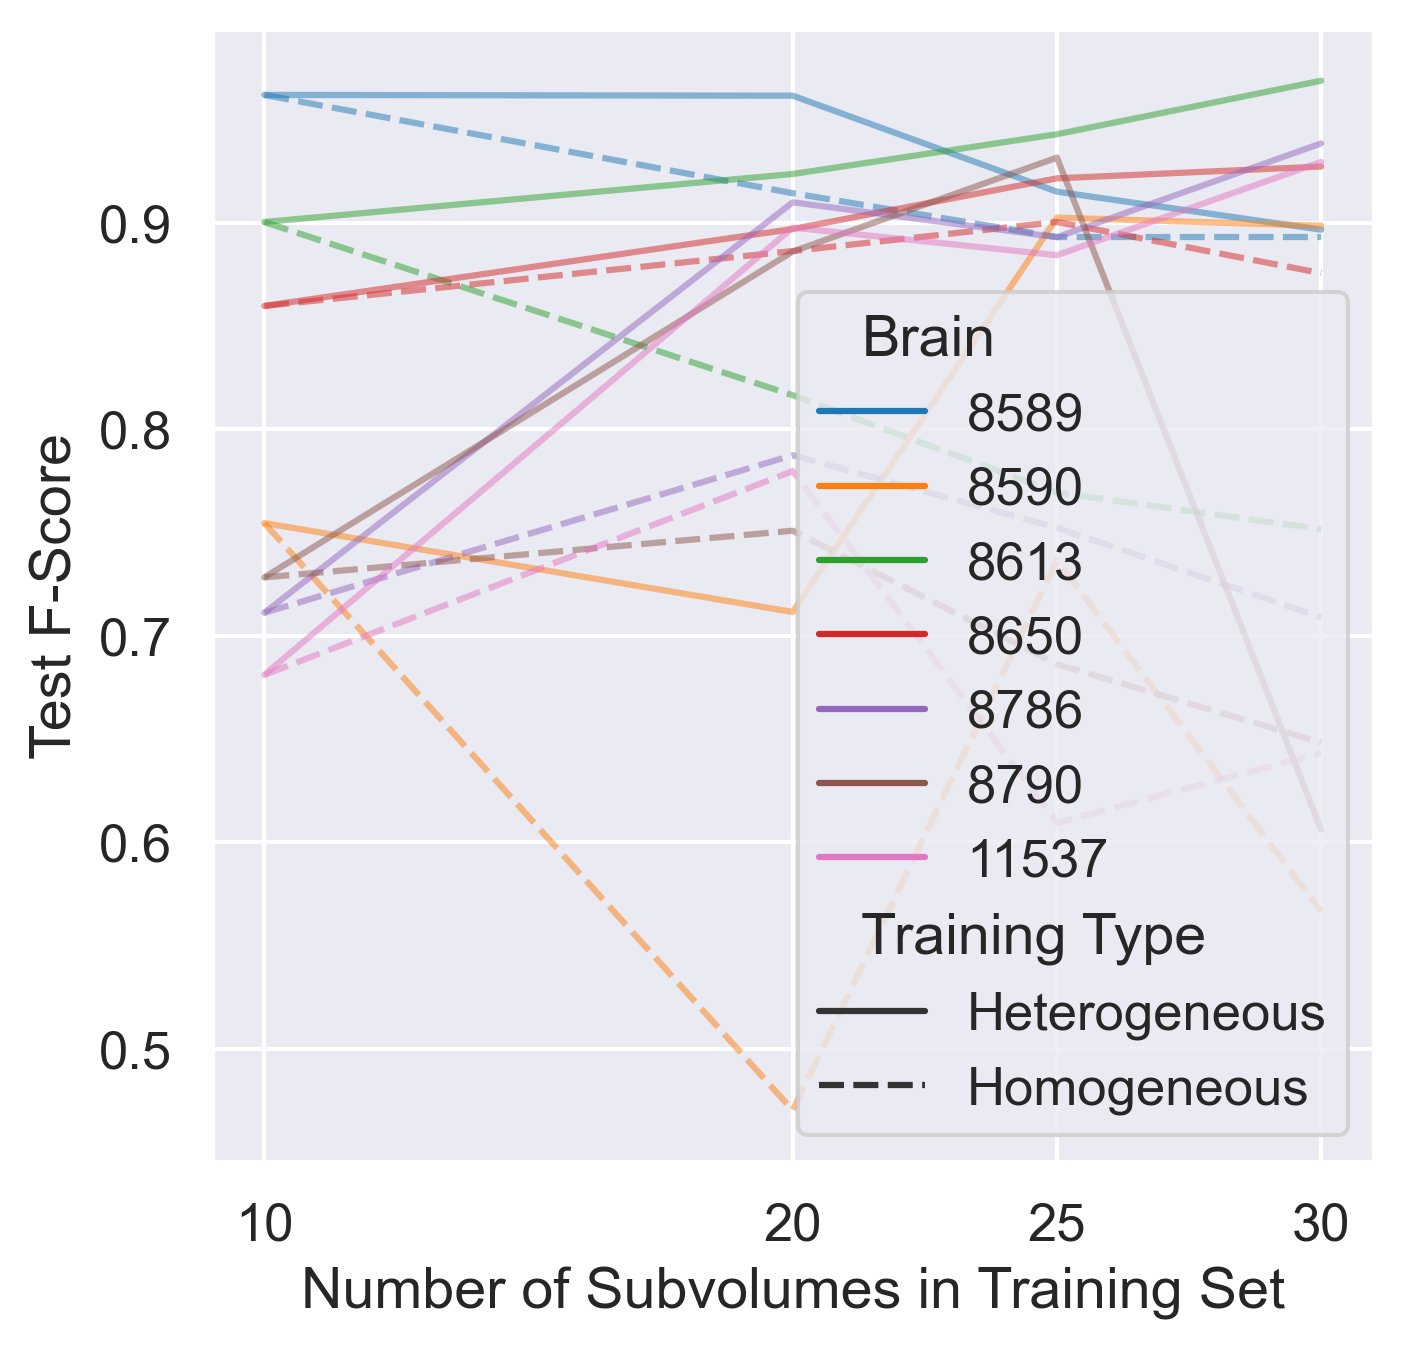

In [26]:
df = pd.DataFrame(
    data={
        "Test F-Score": fscores,
        "Number of Subvolumes in Training Set": train_sizes,
        "Brain": brains,
        "Training Type": model_lines,
    }
)
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
sns.lineplot(
    data=df,
    x="Number of Subvolumes in Training Set",
    y="Test F-Score",
    hue="Brain",
    style="Training Type",
    ax=axes,
    alpha=0.5,
    linestyle="dashed",
    palette="tab10",
)


# axes.plot(np.arange(len(models)), av_fscores, color='red', label="Average")
# leg = axes.legend(loc='lower right')
# leg_lines = leg.get_lines()
# for i in range(len(brain_order)):
#     leg_lines[i].set_linestyle("--")
axes.set_xticks(training_set_sizes)

Text(0.5, 1.0, 'Binary Voxel Classification of Axons')

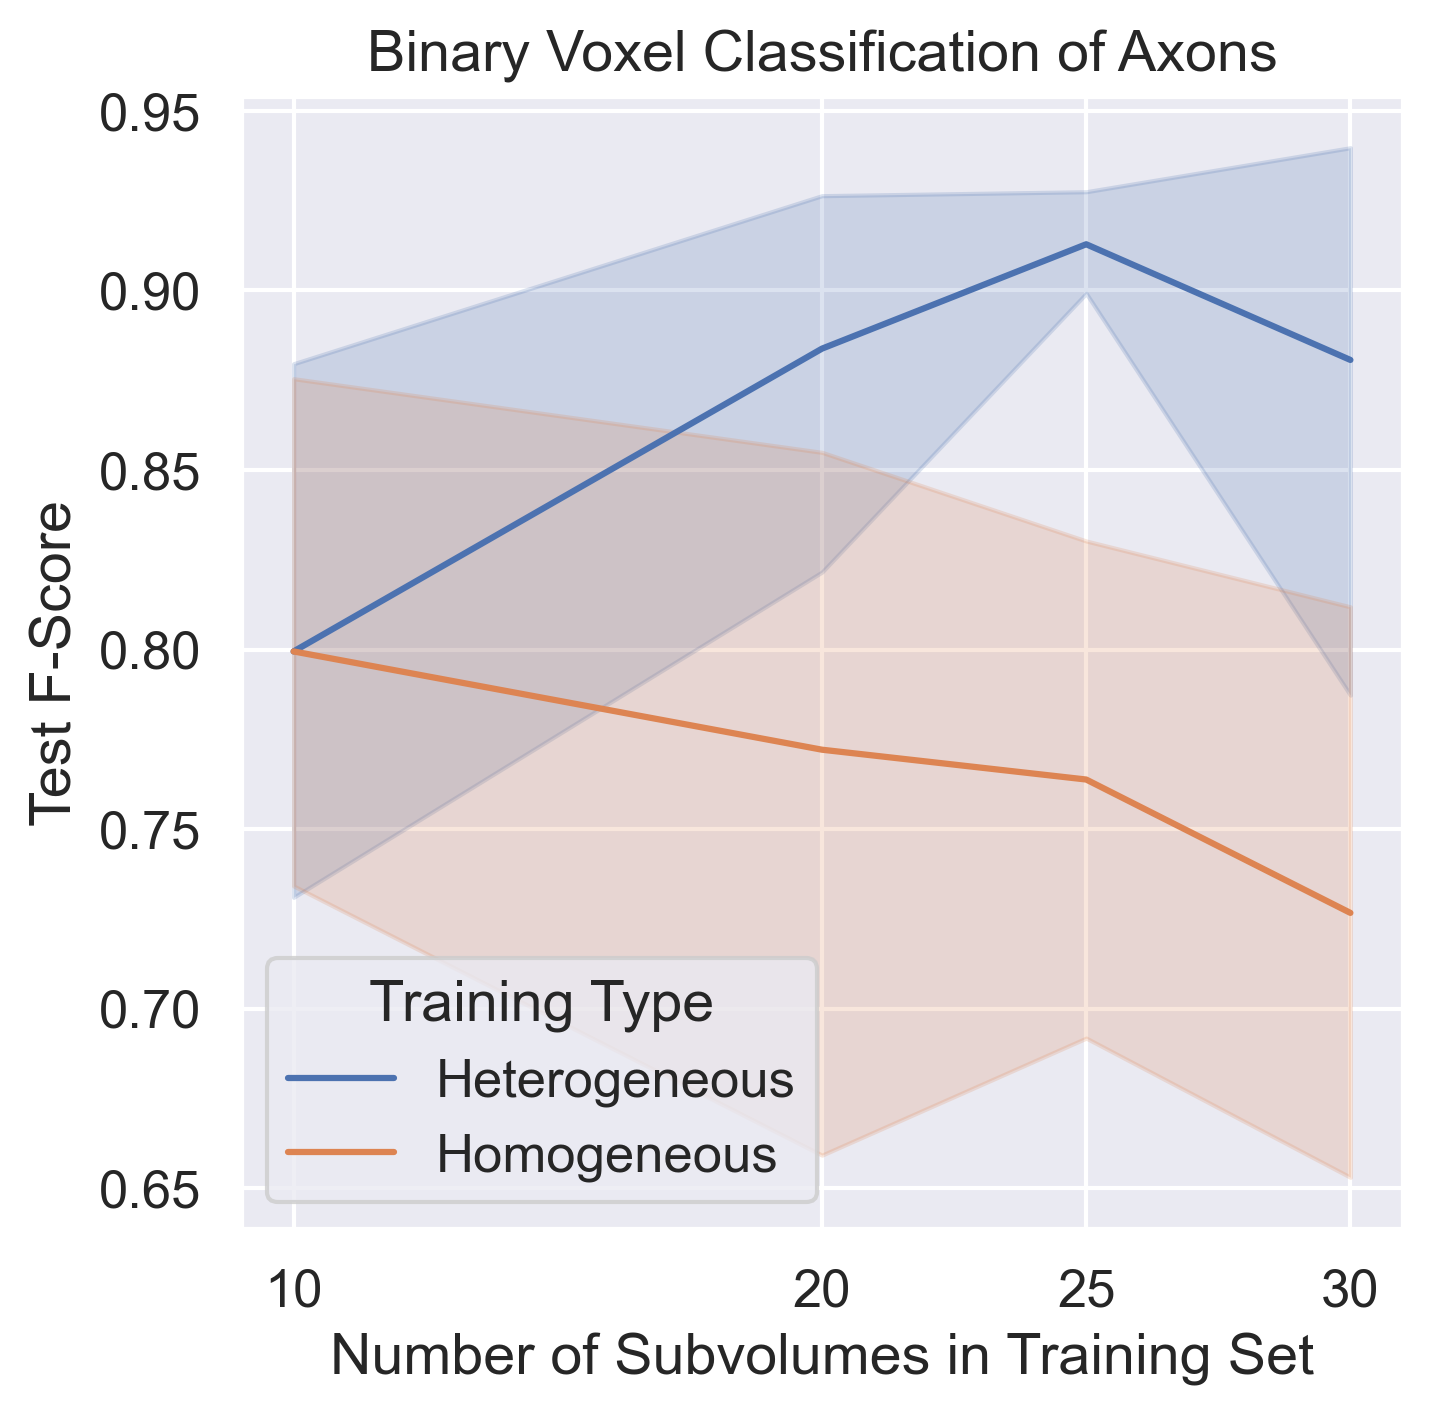

In [28]:
df = pd.DataFrame(
    data={
        "Test F-Score": fscores,
        "Number of Subvolumes in Training Set": train_sizes,
        "Brain": brains,
        "Training Type": model_lines,
    }
)
sns.set(font_scale=1.15)
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
sns.lineplot(
    data=df,
    x="Number of Subvolumes in Training Set",
    y="Test F-Score",
    hue="Training Type",
)
axes.set_xticks(training_set_sizes)
axes.set_title("Binary Voxel Classification of Axons")

# Soma

## Intensity data

In [ ]:
data = {
    "8606": ([1726, 2619, 1687], [3071, 4360, 1687]),
    "8446": ([1979, 3491, 1791], [1258, 3502, 1791]),
    "887": ([3537, 3787, 1385], [2088, 1924, 1385]),
}  # soma center then nonsoma center

intensities = []
brain_ids = []
vol_type = []

for i, brain in enumerate(data.keys()):
    vol = CloudVolume(brain2paths_soma[brain]["base"] + "Ch_647")
    coord = data[brain][0]
    subvol = np.array(
        vol[
            coord[0] - 9 : coord[0] + 10,
            coord[1] - 9 : coord[1] + 10,
            coord[2] - 9 : coord[2] + 10,
        ],
        dtype="float",
    )
    num_entries = len(subvol.flatten())
    intensities += list(subvol.flatten())
    brain_ids += [i] * num_entries
    vol_type += ["Soma"] * num_entries

    coord = data[brain][1]
    subvol = np.array(
        vol[
            coord[0] - 9 : coord[0] + 10,
            coord[1] - 9 : coord[1] + 10,
            coord[2] - 9 : coord[2] + 10,
        ],
        dtype="float",
    )
    num_entries = len(subvol.flatten())
    intensities += list(subvol.flatten())
    brain_ids += [i] * num_entries
    vol_type += ["Background"] * num_entries

df = pd.DataFrame(
    data={"Intensity": intensities, "Subvolume Type": vol_type, "Sample": brain_ids}
)

In [ ]:
sns.set(font_scale=1.15)
fig, axs = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(5, 5))

for i in range(3):
    hist = sns.histplot(
        data=df[df["Sample"] == i],
        x="Intensity",
        hue="Subvolume Type",
        ax=axs[i],
        palette=["green", "red"],
    )
    axs[i].set_title(f"Sample {i}")
    if i > 0:
        hist.get_legend().remove()

axs[0].set_xlim(-500, 8000)
plt.tight_layout()

## Compare to sample number

In [7]:
# training set results
training_brain_order = ["r1", "r2", "878", "887"]
models_diff = []
models_same = []

for i, brain in enumerate(training_brain_order):
    model_diff = "-compare"
    for j, brain2 in enumerate(training_brain_order[: i + 1]):
        model_diff += "-"
        model_diff += str(brain2)

        model_same = "-compare-r1"
        if j > 0:
            model_same += f"_{j+1}"

    models_diff.append(model_diff)
    models_same.append(model_same)

print(f"heterogeneous: {models_diff} homogeneous: {models_same}")

heterogeneous: ['-compare-r1', '-compare-r1-r2', '-compare-r1-r2-878', '-compare-r1-r2-878-887'] homogeneous: ['-compare-r1', '-compare-r1_2', '-compare-r1_3', '-compare-r1_4']


In [8]:
doubles = [
    "3972_1636_1575_pos_Probabilities.h5",
    "2867_4336_1296_pos_Probabilities.h5",
    "2607_1845_1309_pos_Probabilities.h5",
    "2101_3397_1747_pos_Probabilities.h5",
    "2011_3452_1911_pos_Probabilities.h5",
    "2113_3353_1727_pos_Probabilities.h5",
    "1968_3472_1784_pos_Probabilities.h5",
]  # 8446

In [9]:
brain_order = [
    "8607",
    "8606",
    "8477",
    "8531",
    "8608",
    "8529",
    # "8557",
    # "8555",
    "8446",
    "8454",
    # "887",
]
training_set_sizes = [25, 45, 51, 59]
train_sizes = []
model_lines = []
fscores = []
brains = []
size_thresh = 500

for brain in tqdm(brain_order, desc="Evaluating brains..."):
    if brain == "8557":
        brain_name = "r1"
    elif brain == "8555":
        brain_name = "r2"
    else:
        brain_name = brain

    brain_dir = f"/Users/thomasathey/Documents/mimlab/mouselight/ailey/detection_soma/brain{brain_name}/val/"
    # identify images an split into val and test
    files = find_sample_names(brain_dir, dset="", add_dir=False)
    random.shuffle(files)
    half = int(len(files) / 2)
    val_files = files[:half]
    test_files = files[half:]

    for model_line, models in zip(
        ["Heterogeneous", "Homogeneous"], [models_diff, models_same]
    ):
        for model, train_size in zip(models, training_set_sizes):
            results_dir = brain_dir + "results" + model + "/"

            # val - choose best threshold
            pred_files = []
            for val_file in val_files:
                pred_file = f"{results_dir}{val_file.split('.')[0]}_Probabilities.h5"
                pred_files.append(pred_file)

            spacing = 0.02
            thresholds = np.arange(spacing, 1.0, spacing)
            best_fscore = 0
            best_thresh = -1

            for threshold in thresholds:
                tot_pos = 0
                true_pos = 0
                false_pos = 0

                for pred_file in pred_files:
                    if pred_file in doubles:
                        newpos = 2
                    else:
                        newpos = 1

                    f = h5py.File(pred_file, "r")
                    seg = f.get("exported_data")
                    seg = seg[0, :, :, :]
                    mask = seg > threshold
                    labels = measure.label(mask)
                    props = measure.regionprops(labels)

                    if "pos" in pred_file:
                        num_detected = 0
                        tot_pos += newpos
                        for prop in props:
                            if prop["area"] > size_thresh:
                                if num_detected < newpos:
                                    true_pos += 1
                                    num_detected += 1
                                else:
                                    false_pos += 1
                    elif "neg" in pred_file:
                        for prop in props:
                            if prop["area"] > size_thresh:
                                false_pos += 1
                if tot_pos == 0:
                    recall = 1
                else:
                    recall = true_pos / tot_pos

                if true_pos + false_pos == 0:
                    precision = 0
                else:
                    precision = true_pos / (true_pos + false_pos)

                if precision == 0 and recall == 0:
                    fscore = 0
                else:
                    fscore = 2 / (1 / precision + 1 / recall)

                if fscore > best_fscore:
                    best_fscore = fscore
                    best_thresh = threshold

            # test
            pred_files = []
            for val_file in test_files:
                pred_file = f"{results_dir}/{val_file.split('.')[0]}_Probabilities.h5"
                pred_files.append(pred_file)

            tot_pos = 0
            true_pos = 0
            false_pos = 0

            for pred_file in pred_files:
                if pred_file in doubles:
                    newpos = 2
                else:
                    newpos = 1

                f = h5py.File(pred_file, "r")
                seg = f.get("exported_data")
                seg = seg[0, :, :, :]
                mask = seg > best_thresh
                labels = measure.label(mask)
                props = measure.regionprops(labels)

                if "pos" in pred_file:
                    num_detected = 0
                    tot_pos += newpos
                    for prop in props:
                        if prop["area"] > size_thresh:
                            if num_detected < newpos:
                                true_pos += 1
                                num_detected += 1
                            else:
                                false_pos += 1
                elif "neg" in pred_file:
                    for prop in props:
                        if prop["area"] > size_thresh:
                            false_pos += 1

            if tot_pos == 0:
                recall = 1
            else:
                recall = true_pos / tot_pos

            if true_pos + false_pos == 0:
                precision = 0
            else:
                precision = true_pos / (true_pos + false_pos)

            if precision == 0 and recall == 0:
                fscore = 0
            else:
                fscore = 2 / (1 / precision + 1 / recall)

            fscores.append(fscore)
            train_sizes.append(train_size)
            brains.append(brain)

            model_lines.append(model_line)

Evaluating brains...: 100%|██████████| 8/8 [02:30<00:00, 18.81s/it]


[
    <matplotlib.axis.XTick object at 0x15ee85400>,
    <matplotlib.axis.XTick object at 0x15ee853d0>,
    <matplotlib.axis.XTick object at 0x1630d6850>,
    <matplotlib.axis.XTick object at 0x1630f3cd0>
]

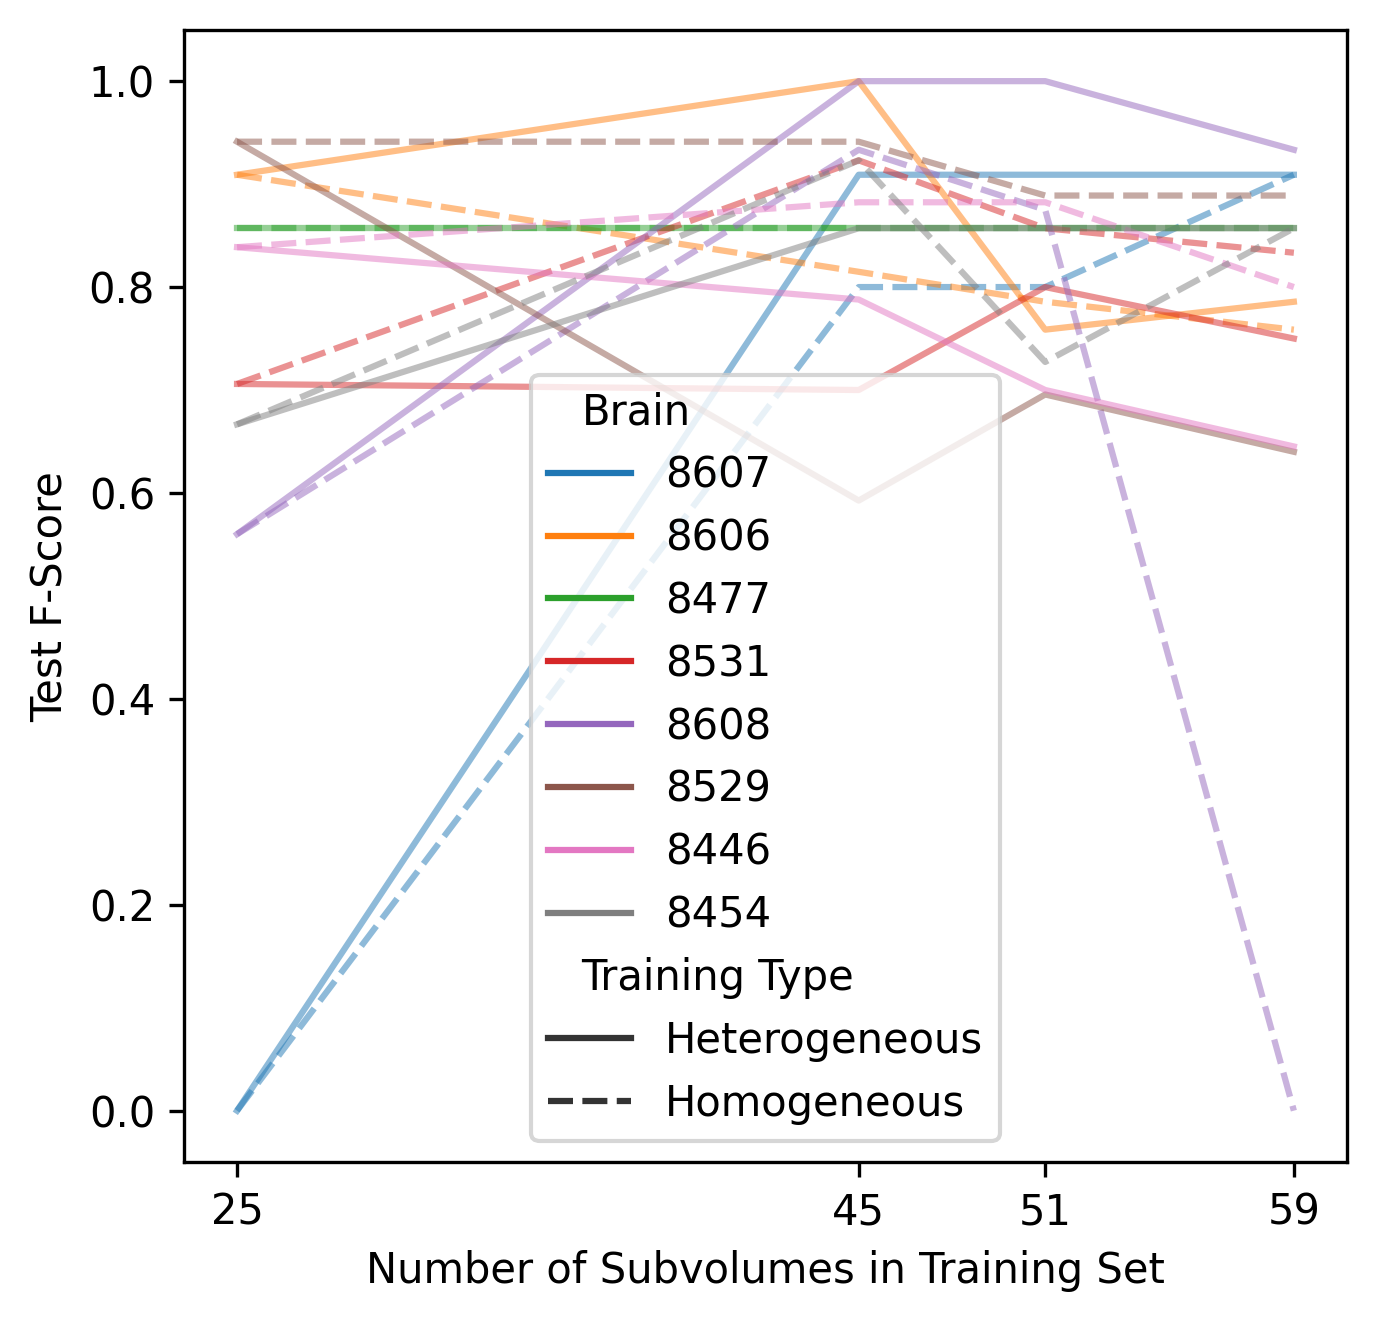

In [10]:
df = pd.DataFrame(
    data={
        "Test F-Score": fscores,
        "Number of Subvolumes in Training Set": train_sizes,
        "Brain": brains,
        "Training Type": model_lines,
    }
)
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
sns.lineplot(
    data=df,
    x="Number of Subvolumes in Training Set",
    y="Test F-Score",
    hue="Brain",
    style="Training Type",
    ax=axes,
    alpha=0.5,
    linestyle="dashed",
    palette="tab10",
)


# axes.plot(np.arange(len(models)), av_fscores, color='red', label="Average")
# leg = axes.legend(loc='lower right')
# leg_lines = leg.get_lines()
# for i in range(len(brain_order)):
#     leg_lines[i].set_linestyle("--")
axes.set_xticks(training_set_sizes)

[
    <matplotlib.axis.XTick object at 0x1632c9190>,
    <matplotlib.axis.XTick object at 0x1632c9160>,
    <matplotlib.axis.XTick object at 0x1632b7b50>,
    <matplotlib.axis.XTick object at 0x163314160>
]

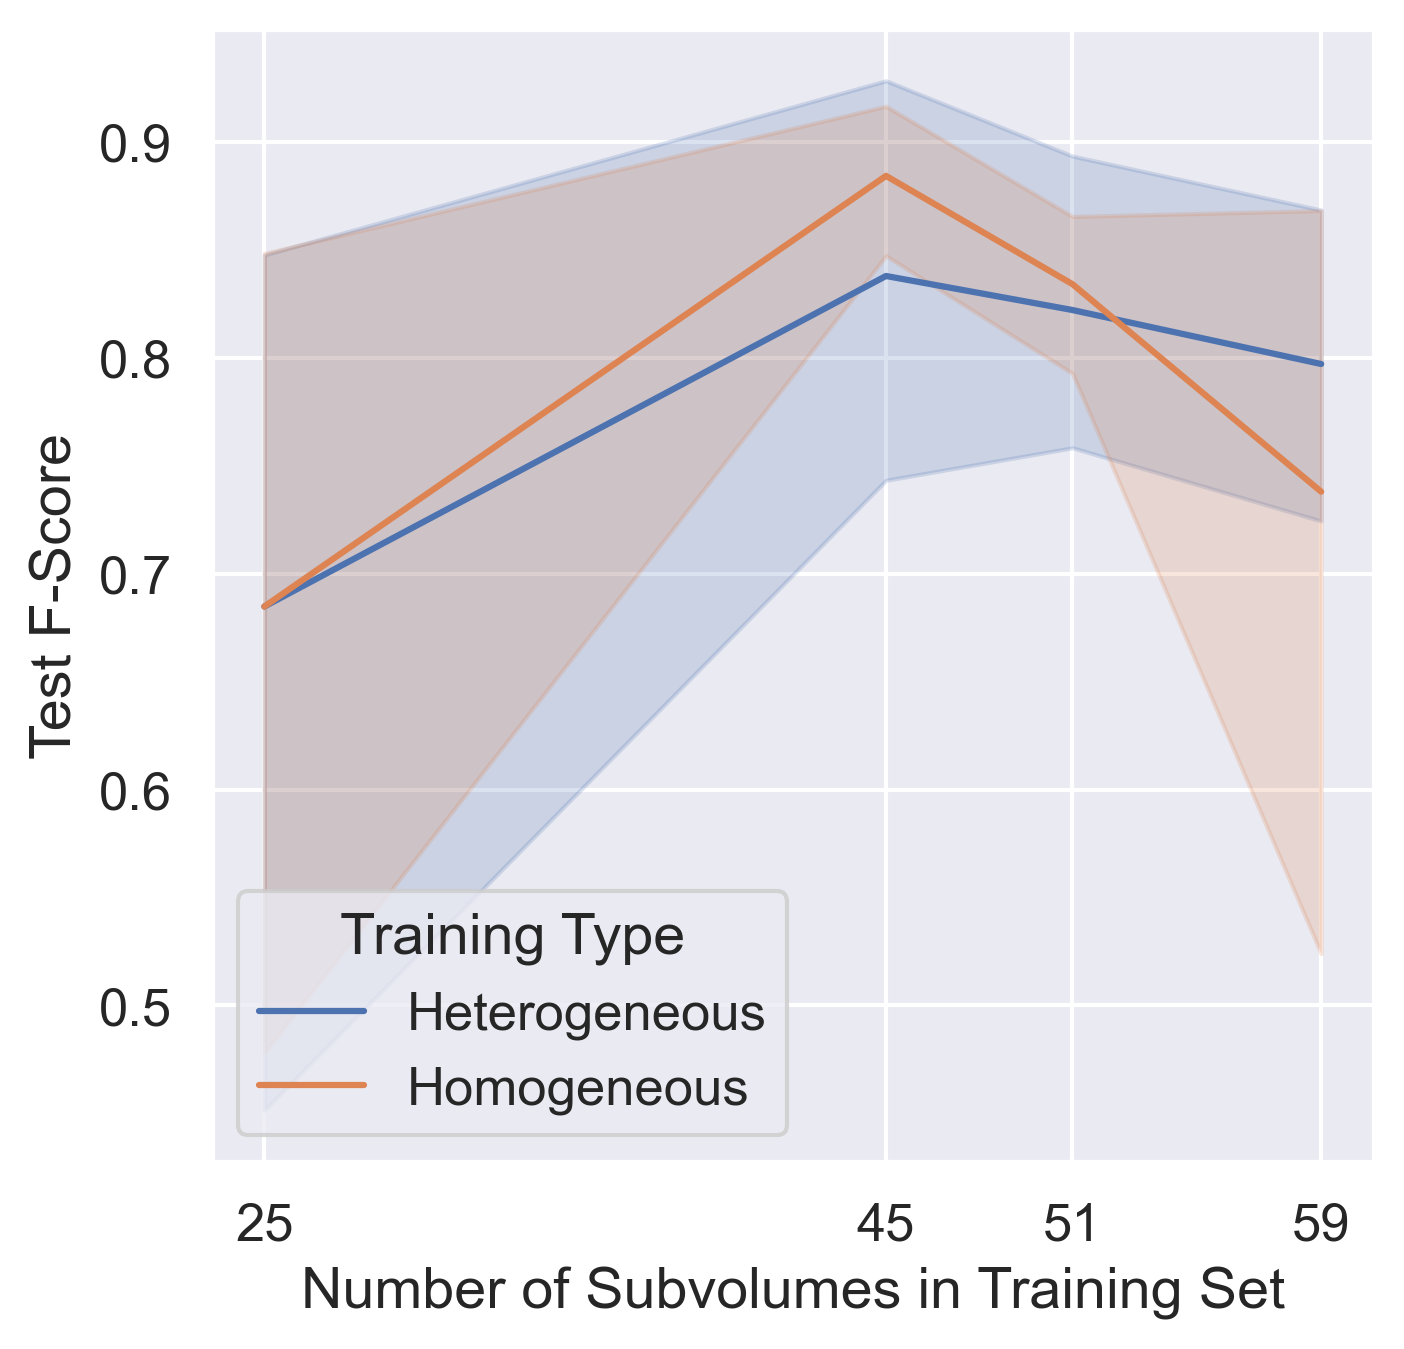

In [11]:
df = pd.DataFrame(
    data={
        "Test F-Score": fscores,
        "Number of Subvolumes in Training Set": train_sizes,
        "Brain": brains,
        "Training Type": model_lines,
    }
)
sns.set(font_scale=1.15)
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
sns.lineplot(
    data=df,
    x="Number of Subvolumes in Training Set",
    y="Test F-Score",
    hue="Training Type",
)
axes.set_xticks(training_set_sizes)